In [14]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import patches
from matplotlib.figure import Figure
from matplotlib import rcParams
import scipy.io


In [15]:
# A00001 ---> yeh Normak vala hai
# A00004 ---> yeh Af vala hai 
# A00022 ---> yeh noisy hai 
# A00008 ---> yeh other vala hai

Text(0.5, 0, 'Normal ECG')

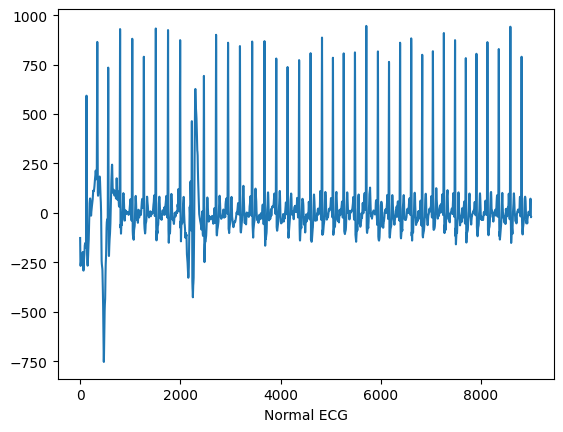

In [16]:
# extracting ecg from normal file
mat_normal = scipy.io.loadmat('./A00001.mat')
ecg = mat_normal.get('val')
plt.plot(ecg[0])
plt.xlabel('Normal ECG')

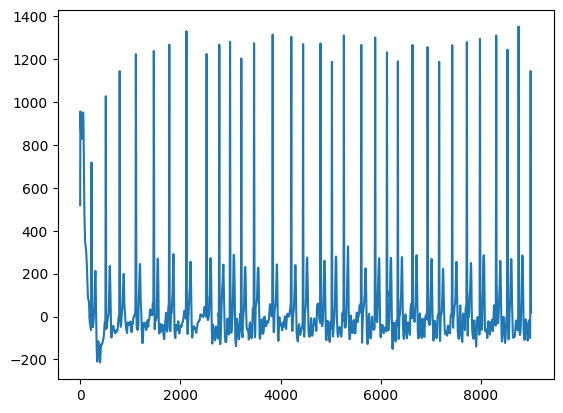

In [17]:
# extracting ecg from af file
mat_af = scipy.io.loadmat('./A00004.mat')
ecg = mat_af.get('val')
plt.plot(ecg[0])
plt.xlabel('Aterial Febilation ECG')

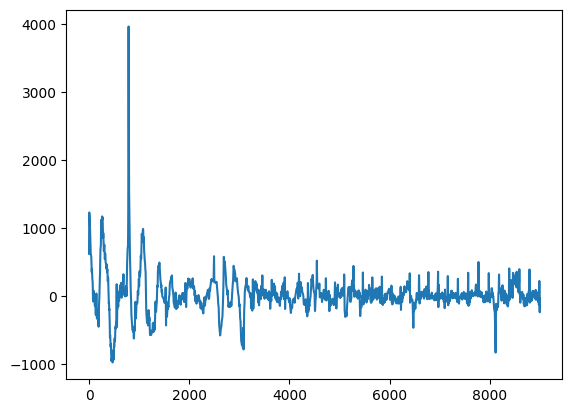

In [18]:
# extracting ecg from noisy file
mat_noisy = scipy.io.loadmat('./A00022.mat')
ecg = mat_noisy.get('val')
plt.plot(ecg[0])

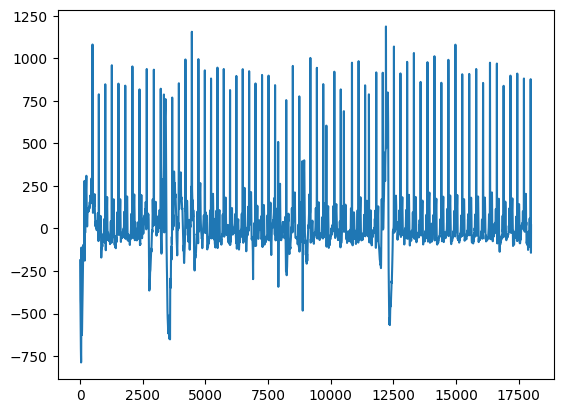

In [19]:
# extracting ecg from others file
mat_others = scipy.io.loadmat('./A00008.mat')
ecg = mat_others.get('val')
plt.plot(ecg[0])

In [20]:

def detect_beats(
        ecg,    # The raw ECG signal
        rate,    # Sampling rate in HZ
        # Window size in seconds to use for 
        ransac_window_size=5.0,
        # Low frequency of the band pass filter
        lowfreq=5.0,
        # High frequency of the band pass filter
        highfreq=15.0,
        ):
    # """
    # ECG heart beat detection based on
    # http://link.springer.com/article/10.1007/s13239-011-0065-3/fulltext.html
    # with some tweaks (mainly robust estimation of the rectified signal
    # cutoff threshold).
    # """

    ransac_window_size = int(ransac_window_size*rate)

    lowpass = scipy.signal.butter(1, highfreq/(rate/2.0), 'low')
    highpass = scipy.signal.butter(1, lowfreq/(rate/2.0), 'high')
    # TODO: Could use an actual bandpass filter
    ecg_low = scipy.signal.filtfilt(*lowpass, x=ecg)
    ecg_band = scipy.signal.filtfilt(*highpass, x=ecg_low)
    
    # Square (=signal power) of the first difference of the signal
    decg = np.diff(ecg_band)
    decg_power = decg**2
    
    # Robust threshold and normalizator estimation
    thresholds = []
    max_powers = []
    for i in range(int(len(decg_power)/ransac_window_size)):
        sample = slice(i*ransac_window_size, (i+1)*ransac_window_size)
        d = decg_power[sample]
        thresholds.append(0.5*np.std(d))
        max_powers.append(np.max(d))

    threshold = 0.5*np.std(decg_power)
    threshold = np.median(thresholds)
    max_power = np.median(max_powers)
    decg_power[decg_power < threshold] = 0

    decg_power /= max_power
    decg_power[decg_power > 1.0] = 1.0
    square_decg_power = decg_power**2

    shannon_energy = -square_decg_power*np.log(square_decg_power)
    shannon_energy[~np.isfinite(shannon_energy)] = 0.0

    mean_window_len = int(rate*0.125+1)
    lp_energy = np.convolve(shannon_energy, [1.0/mean_window_len]*mean_window_len, mode='same')
    #lp_energy = scipy.signal.filtfilt(*lowpass2, x=shannon_energy)
    
    lp_energy = scipy.ndimage.gaussian_filter1d(lp_energy, rate/8.0)
    lp_energy_diff = np.diff(lp_energy)

    zero_crossings = (lp_energy_diff[:-1] > 0) & (lp_energy_diff[1:] < 0)
    zero_crossings = np.flatnonzero(zero_crossings)
    zero_crossings -= 1
    return zero_crossings


def plot_peak_detection(ecg, rate):
    import matplotlib.pyplot as plt
    dt = 1.0/rate
    t = np.linspace(0, len(ecg)*dt, len(ecg))
    plt.plot(t, ecg)

    peak_i = detect_beats(ecg, rate)
    plt.scatter(t[peak_i], ecg[peak_i], color='red')
    plt.show()


if __name__ == '__main__':
    rate = float(sys.argv[1])
    
    ecg = np.loadtxt(sys.stdin)
    if len(sys.argv) > 2 and sys.argv[2] == 'plot':
        plot_peak_detection(ecg, rate)
    else:    
        peaks = detect_beats(ecg, rate)
        sys.stdout.write("\n".join(map(str, peaks)))
    sys.stdout.write("\n")


NameError: name 'sys' is not defined